In [1]:
!pwd
!export PYTHONPATH=$PYTHONPATH:$(pwd)/evidential-learning-pytorch

import sys
print(sys.path)
sys.path.append('/work/DRO-EDL/1d/evidential-learning-pytorch')

from tqdm import tqdm
from scipy.stats import norm

import numpy as np
from scipy.stats import norm, invgamma

import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.integrate import dblquad

import torch

from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from edl_pytorch import NormalInvGamma, evidential_regression

import torch.optim as optim

/work/DRO-EDL/2d
['/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/opencda/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages']


In [21]:
def cart2polar(x,y):
    r = (x**2 + y**2)**(1/2)
    theta = np.arctan2(y,x)
    return r , theta

def polar2cart(r,theta):
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x,y

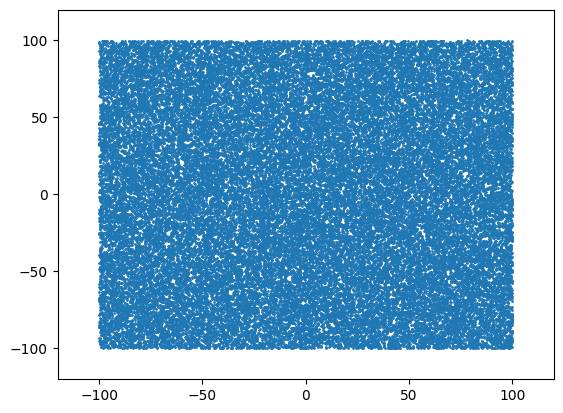

In [22]:
# create y sample
num_sample = 50000
x_range, y_range = [-100, 100], [-100, 100]
x = np.random.uniform(*x_range, num_sample)
y = np.random.uniform(*y_range, num_sample)
plt.scatter(x,y, s=1)
plt.xlim(-120, 120)
plt.ylim(-120, 120)
plt.show()

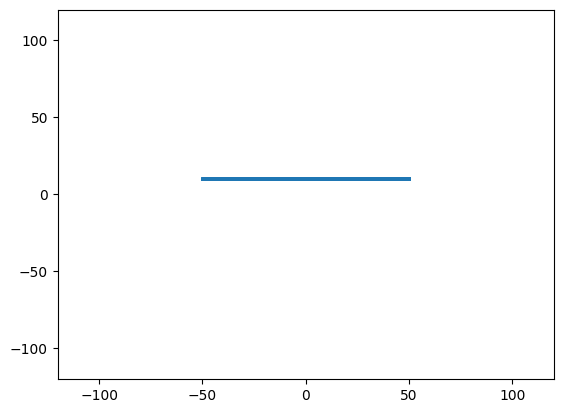

In [4]:
# create y sample
num_sample = 50000
x_range, y_range = [-50, 50], [10, 10.5]
x = np.random.uniform(*x_range, num_sample)
y = np.random.uniform(*y_range, num_sample)
plt.scatter(x,y, s=1)
plt.xlim(-120, 120)
plt.ylim(-120, 120)
plt.show()

In [23]:
x = torch.tensor(x, dtype=torch.float)[:,None]
y = torch.tensor(y, dtype=torch.float)[:,None]

In [24]:

train_data = torch.concat([x, y], axis=1)
sigma = torch.normal(torch.zeros_like(train_data[:,0]), 1 * torch.ones_like(train_data[:,0])).unsqueeze(-1)
y_train = train_data[:,1].unsqueeze(-1) + sigma
x_train = torch.tensor([cart2polar(x,y) for x,y in train_data])


# test_data = torch.concat([x, y], axis=1)
test_data = torch.concat([10*torch.ones(1000).unsqueeze(-1), torch.linspace(-200, 200, 1000).unsqueeze(-1)], axis=1)
y_test = test_data[:,1].unsqueeze(-1)
x_test = torch.tensor([cart2polar(x,y) for x,y in test_data])

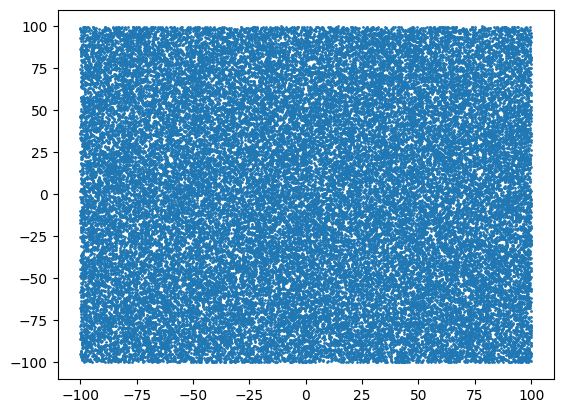

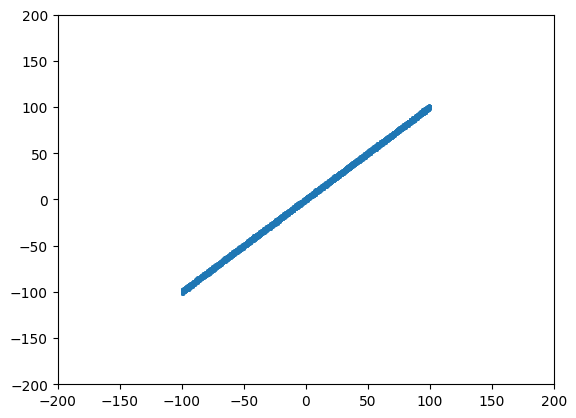

In [25]:
plt.scatter(train_data[:,0], train_data[:,1], s=1)
# plt.ylim(8,12)
plt.show()
# train_data[:5]
plt.scatter(train_data[:,1], y_train, s=1)
plt.xlim(-200, 200)
plt.ylim(-200, 200)
plt.show()

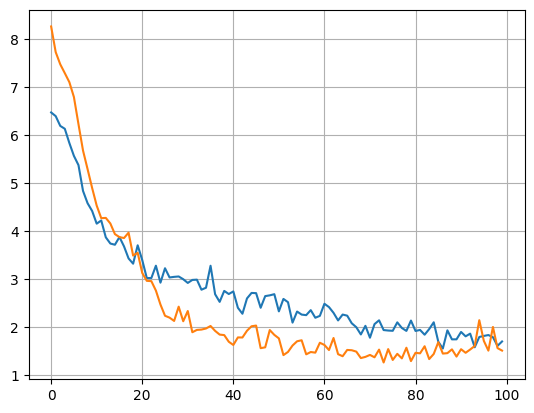

100%|█████████████████████████████████████████| 100/100 [01:07<00:00,  1.47it/s]


In [26]:
from IPython.display import clear_output

torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    NormalInvGamma(64, 1),
)
err = False
model = model.to('cuda:0')
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
train_loss_list = list()
val_loss_list = list()

fig, ax = plt.subplots()
for epoch in tqdm(range(100)):
    for x, y in DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True):
        x, y = x.to('cuda:0'), y.to('cuda:0')
        pred = model(x)
        loss = evidential_regression(pred, y, lamb=1e-2)
        if loss.isnan():
            print("nan!")
            err = True
            break
        # if pred[2].min() == 1:
        #     print("alpha=1")
        #     err = True
        #     break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if err:
        break
    train_loss_list.append(loss.detach().cpu())
    with torch.no_grad():
        x_test, y_test = x_test.to('cuda:0'), y_test.to('cuda:0')
        pred = model(x_test)
        loss = evidential_regression(pred, y_test, lamb=1e-2)
        val_loss_list.append(loss.detach().cpu())
    torch.save(model.state_dict(), f'uncertain_weights/{epoch}.pth')

    clear_output(wait=True)
    plt.plot(train_loss_list)
    plt.plot(val_loss_list)
    plt.grid(True)
    plt.pause(0.0001)
plt.show()


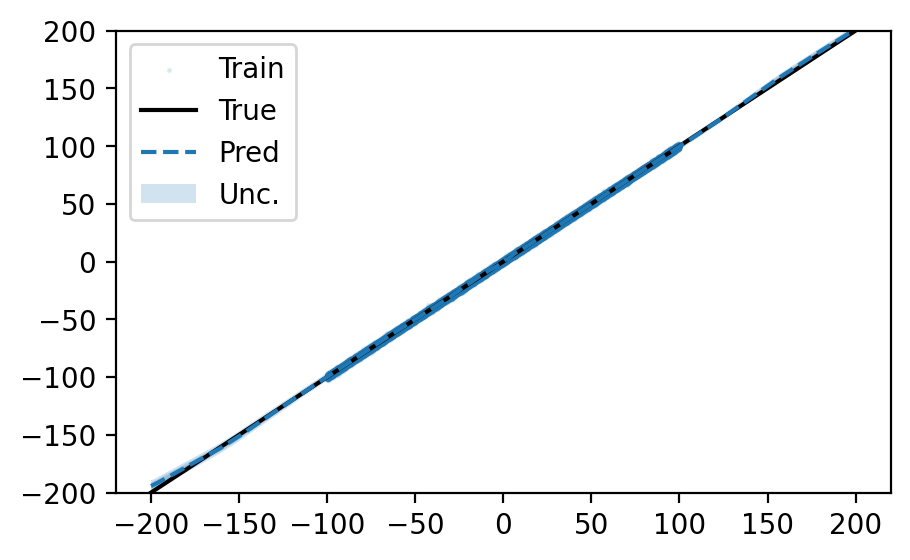

In [27]:
# model.load_state_dict(torch.load('uncertain_weights/17.pth'))
model.cpu()
x_train, x_test = x_train.cpu(), x_test.cpu()
y_train, y_test = y_train.cpu(), y_test.cpu()
with torch.no_grad():
    pred = model(x_test)

mu, v, alpha, beta = (d.squeeze() for d in pred)
x_test = x_test.squeeze()
ep_var = torch.sqrt(beta / (v * (alpha - 1)))
al_var = torch.sqrt(beta / (alpha - 1))

# plot code modified from
# https://github.com/aamini/evidential-deep-learning/blob/main/hello_world.py#L48
plt.figure(figsize=(5, 3), dpi=200)
x_train_data = [polar2cart(x,y)[1] for x,y in x_train]
x_test_data = [polar2cart(x,y)[1] for x,y in x_test]
plt.scatter(x_train_data, y_train, s=1.0, c="tab:blue", label="Train", alpha=0.1)
plt.plot(x_test_data, y_test, c="k", label="True")
plt.plot(x_test_data, mu, c="tab:blue", ls="--", label="Pred")
for std in range(4):
    plt.fill_between(
        x_test_data,
        (mu - std * ep_var),
        (mu + std * ep_var),
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 0 else None,
    )
plt.gca().set_ylim(-200, 200)
# plt.gca().set_xlim(-7, 7)
plt.legend(loc="upper left")
plt.show()

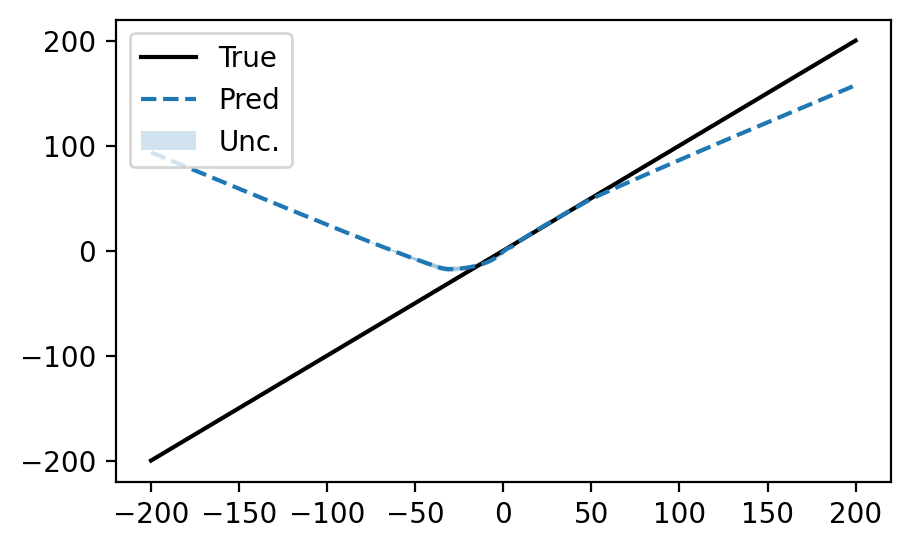

In [83]:

with torch.no_grad():
    pred = model(x_test)

mu, v, alpha, beta = (d.squeeze() for d in pred)
x_test = x_test.squeeze()
ep_var = torch.sqrt(beta / (v * (alpha - 1)))
al_var = torch.sqrt(beta / (alpha - 1))

# plot code modified from
# https://github.com/aamini/evidential-deep-learning/blob/main/hello_world.py#L48
plt.figure(figsize=(5, 3), dpi=200)
x_train_data = [polar2cart(x,y)[0] for x,y in x_train]
x_test_data = [polar2cart(x,y)[0] for x,y in x_test]
# plt.scatter(x_train_data, y_train, s=1.0, c="tab:blue", label="Train", alpha=0.1)
plt.plot(x_test_data, y_test, c="k", label="True")
plt.plot(x_test_data, mu, c="tab:blue", ls="--", label="Pred")
for std in range(4):
    plt.fill_between(
        x_test_data,
        (mu - std * al_var),
        (mu + std * al_var),
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 0 else None,
    )
# plt.gca().set_ylim(-20, 20)
# plt.gca().set_xlim(-7, 7)
plt.legend(loc="upper left")
plt.show()

tensor(24.5527) tensor(5.6708e-09) tensor(1.1789) tensor(0.0001)
tensor(-8.1097) tensor(2.5270e-05) tensor(1.1414) tensor(0.0521)
tensor(-17.6947) tensor(0.0015) tensor(1.3027) tensor(0.2491)
tensor(-0.9757) tensor(0.1062) tensor(1.5619) tensor(0.3667)
tensor(9.8510) tensor(0.0738) tensor(1.8258) tensor(0.1283)
tensor(30.3125) tensor(0.0056) tensor(2.4639) tensor(0.0100)
tensor(49.2096) tensor(0.0002) tensor(2.9867) tensor(0.0006)
tensor(86.2489) tensor(4.5383e-08) tensor(3.6274) tensor(8.7520e-07)


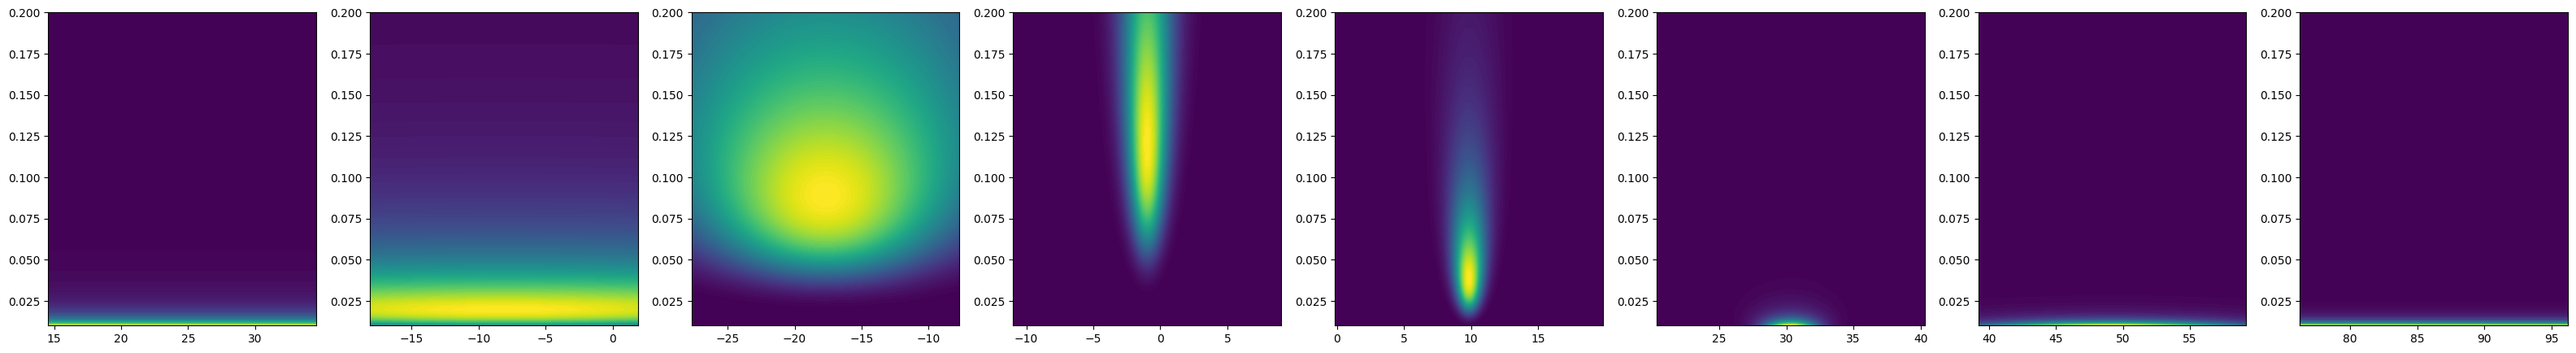

In [84]:
def nig_joint_pdf(mu, sigma2, mu_0, lambda_, alpha, beta):
    # Normal part (mean = mu, variance = sigma2)
    norm_pdf = norm.pdf(mu, mu_0, np.sqrt(sigma2 / lambda_))
    
    # Inverse gamma part (variance = sigma2)
    invgamma_pdf = invgamma.pdf(sigma2, alpha, scale=beta)
    
    return norm_pdf * invgamma_pdf

# CDF에 해당하는 등고선 계산
def calculate_cdf_contour_level(pdf_values, target_cdf):
    # 확률밀도함수 값들을 1D로 변환한 후 정렬
    sorted_pdf = np.sort(pdf_values.flatten())[::-1]
    cumulative_sum = np.cumsum(sorted_pdf)
    cumulative_sum /= cumulative_sum[-1]  # 누적 합을 0~1 사이의 값으로 정규화
    
    # CDF에 해당하는 값을 찾기
    contour_value = sorted_pdf[np.searchsorted(cumulative_sum, target_cdf)]
    return contour_value

data = [-100, -50, -30, 0, 10, 30, 50, 100]


fig, ax = plt.subplots(1, len(data), figsize=(5*len(data),5))

for fig_idx, x in enumerate(data):
    with torch.no_grad():
        pred = model(torch.tensor(cart2polar(x,10), dtype=torch.float))
    
    mu_0, lambda_, alpha, beta = (d.squeeze() for d in pred)
    print(mu_0, lambda_, alpha, beta)
    
    
    mu_values = np.linspace(mu_0 - 10, mu_0 + 10, 100)
    sigma2_values = np.linspace(0.01, 0.2, 100)
    # 그리드를 만들어 결합 확률 밀도를 계산
    mu_grid, sigma2_grid = np.meshgrid(mu_values, sigma2_values)
    std_pdf_values = nig_joint_pdf(mu_grid, sigma2_grid, mu_0, lambda_, alpha, beta)
    
    # 입력받은 CDF 값에 해당하는 등고선 값을 계산
    # contour_level = calculate_cdf_contour_level(std_pdf_values, target_cdf)
    ax[fig_idx].contourf(mu_grid, sigma2_grid, std_pdf_values, levels=np.linspace(0, std_pdf_values.max(), 100), cmap='viridis')
plt.show()

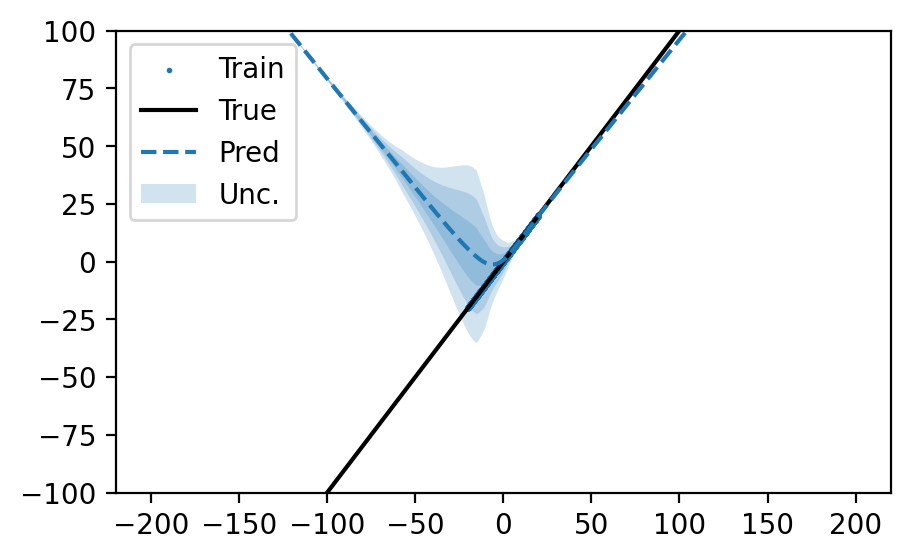

In [137]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from edl_pytorch import NormalInvGamma, evidential_regression

import numpy as np
import torch.optim as optim

torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    NormalInvGamma(64, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
train_loss_list = list()
val_loss_list = list()
for epoch in range(50):
    for x, y in DataLoader(TensorDataset(x_train, y_train), batch_size=100, shuffle=True):
        pred = model(x)
        loss = evidential_regression(pred, y, lamb=1e-2)
        if loss.isnan():
            print("nan!")
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss_list.append(loss.detach().cpu())
    with torch.no_grad():
        pred = model(x_test)
        loss = evidential_regression(pred, y_test, lamb=1e-2)
        val_loss_list.append(loss.detach().cpu())

    # torch.save(model.state_dict(), f'weights/{epoch}.pth')

with torch.no_grad():
    pred = model(x_test)

mu, v, alpha, beta = (d.squeeze() for d in pred)
x_test = x_test.squeeze()
var = torch.sqrt(beta / (v * (alpha - 1)))

# plot code modified from
# https://github.com/aamini/evidential-deep-learning/blob/main/hello_world.py#L48
plt.figure(figsize=(5, 3), dpi=200)
x_train_data = [polar2cart(x,y)[0] for x,y in x_train]
x_test_data = [polar2cart(x,y)[0] for x,y in x_test]
plt.scatter(x_train_data, y_train, s=1.0, c="tab:blue", label="Train")
plt.plot(x_test_data, y_test, c="k", label="True")
plt.plot(x_test_data, mu, c="tab:blue", ls="--", label="Pred")
for std in range(4):
    plt.fill_between(
        x_test_data,
        (mu - std * var),
        (mu + std * var),
        alpha=0.2,
        facecolor="tab:blue",
        label="Unc." if std == 0 else None,
    )
plt.gca().set_ylim(-100, 100)
# plt.gca().set_xlim(-7, 7)
plt.legend(loc="upper left")
plt.show()

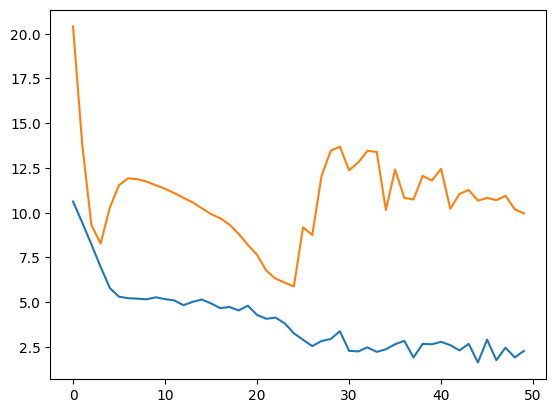

In [127]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.show()